In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

F_comp = 80 # flux completeness %
min_count = 4 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(6, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

In [26]:
# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN8.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN8.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN8.csv', index_col='Seq')

# All CIGALE sources
oCDFS = pd.read_csv('../DATA/CIGALE/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/CIGALE/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/CIGALE/UDS/results.txt', delim_whitespace=True, index_col='id')

# fin_idx = pd.read_csv('final_index.csv', index_col=0)

In [27]:
def mask_data(zfourge, cigale):
    
    # Use Mask
    use_mask = zfourge['Use'] == 1
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    
    # Redshift Mask
    red_mask = (zfourge['zpk'] > redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    
    # CIGALE Redshift Mask
    cgz_mask = (cigale['bayes.universe.redshift'] > redshift_bins[0][0]) & (cigale['bayes.universe.redshift'] <= redshift_bins[-1][1])
    zfourge = zfourge.loc[cgz_mask]
    cigale = cigale.loc[cgz_mask]
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    return zfourge, cigale

print(f'Total number of sources CIGALE: {len(oCDFS) + len(oCOSMOS) + len(oUDS)} \n')
CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS)
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS)
UDS_m, oUDS_m = mask_data(UDS, oUDS)

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Reduced Number of CIGALE sources: {len(odf)}')


Total number of sources CIGALE: 73758 

Reduced Number of CIGALE sources: 37572


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\danie\AppData\Local\Temp\ipykernel_14104\2534104125.py:45: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


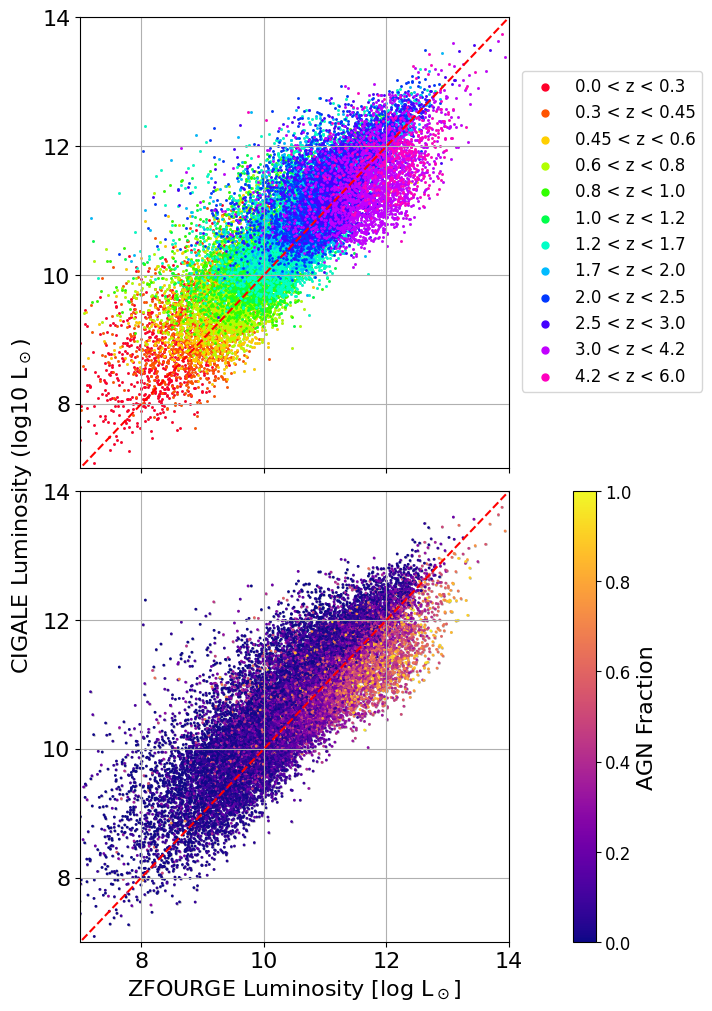

In [28]:
# common_sources = fin_idx.index.intersection(odf.index)
# r_odf = odf.loc[common_sources]
# r_df = df.loc[common_sources]
# print(f'Final Number of CIGALE sources: {len(r_odf)}')

# plt.scatter(df['zpk'], odf['bayes.universe.redshift'], s=1, c='black', alpha=0.5)
# plt.show()

colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))

fig, ax = plt.subplots(2, 1, figsize=(7, 10), sharex=True, sharey=True, layout='constrained')
ax[0].scatter(np.log10(df['LIR']), np.log10((odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])*(2.612 * 10**(-27))), s=1, c='grey', alpha=0.5)
ax[1].scatter(np.log10(df['LIR']), np.log10((odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])*(2.612 * 10**(-27))), s=1, c='grey', alpha=0.5)

zf_lum = df['LIR'] # Solar Luminosity
cg_lum = (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])*(2.612 * 10**(-27)) # Solar Luminosity
x = np.linspace(5, 15, 100)
for (z_start, z_end), c in zip(redshift_bins, colors):
    z_mask = (df['zpk'] > z_start) & (df['zpk'] <= z_end)
    ax[0].scatter(np.log10(zf_lum[z_mask]), np.log10(cg_lum[z_mask]), s=1, color=c, label=f'{z_start} < z < {z_end}')
ax[0].plot(x, x, linestyle='--', color='red')

sc = ax[1].scatter(np.log10(zf_lum), np.log10(cg_lum), s=1, c=odf['bayes.agn.fracAGN'], cmap='plasma', vmin=0, vmax=1)
cbar = fig.colorbar(sc, ax=ax[1], label='AGN Fraction', orientation='vertical', pad=-0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('AGN Fraction', fontsize=16)
ax[1].plot(x, x, linestyle='--', color='red')

ax[0].grid()
ax[1].grid()

ax[1].set_xlabel('ZFOURGE Luminosity [log L$_\odot$]', fontsize=16)
fig.supylabel('CIGALE Luminosity (log10 L$_\odot$)', fontsize=16)

ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)

ax[0].set_xlim(7, 14)
ax[0].set_ylim(7, 14)
ax[0].set_xticks([8,10,12,14])
ax[0].set_yticks([8,10,12,14])

ax[0].legend(bbox_to_anchor=(1.01, 0.90), fontsize=12, markerscale=5)

plt.subplots_adjust(hspace=0)
# plt.savefig('LIR_vs_LIR', dpi=300)
plt.show()

### Total Luminosity

In [ ]:
luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values + odf['bayes.agn.luminosity'].values # Watts
lum_err = np.sqrt(odf['bayes.stellar.lum_err'].values**2 + odf['bayes.dust.luminosity_err'].values**2 + odf['bayes.agn.luminosity_err'].values**2) # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = np.maximum(luminosity - lum_err, 0)

### Stellar Luminosity

In [ ]:
luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values # Watts
lum_err = np.sqrt(odf['bayes.stellar.lum_err'].values**2 + odf['bayes.dust.luminosity_err'].values**2) # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = np.maximum(luminosity - lum_err, 0)

### AGN Lumminosity

In [29]:
# Low AGN Fraction Mask
agn_frac = odf['bayes.agn.fracAGN'].values
mask_low_agn = agn_frac > 0.1
df = df.loc[mask_low_agn]
odf = odf.loc[mask_low_agn]
print(f'Number of sources AGN>0.1: {len(odf)}')

luminosity = odf['bayes.agn.luminosity'].values # Watts
lum_err = odf['bayes.agn.luminosity_err'].values # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = luminosity*(luminosity/lum_err_up)

Number of sources AGN>0.1: 21061


In [ ]:
z = odf['bayes.universe.redshift'].values.copy() # redshift
d_L = cosmo.luminosity_distance(z).to('m').value # m # Luminsity distance of galaxies

def mask_flux(luminosity):

    # Bolometric Flux
    F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2

    # Bolometric Flux Limit
    Fbol_lim = np.percentile(F_bol, 100-F_comp) # % of the data above perc

    # Bolometric Flux Masks
    mask_fbol = F_bol > Fbol_lim
    return mask_fbol, Fbol_lim

mask_fbol, Fbol_lim = mask_flux(luminosity)
mask_fbol_up, Fbol_lim_up = mask_flux(lum_err_up)
mask_fbol_dn, Fbol_lim_dn = mask_flux(lum_err_dn)

print(f'Flux Limit: {Fbol_lim}')
print(f'Number of galaxies: {len(z[mask_fbol])}')
print(f'Bolometric Flux Completeness: {Fbol_lim:.2e} W/m^2')

Number of sources: 14957


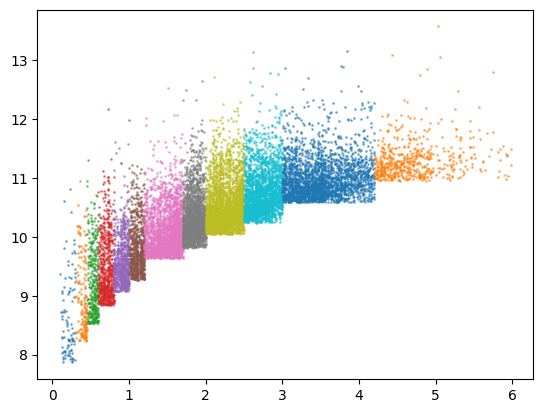

In [30]:
def lum_lim(z, f_lim):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # W

def compute_volume(redshift_bins, luminosity, Fbol_lim, mask_fbol):
    """ Compute the volume of each redshift bin """
    all_data = []
    L_lims = []
    bin_zs = []
    
    for z_start, z_end in redshift_bins:
        mask_z = (z >= z_start) & (z < z_end)
        
        # Source lumiosity must be greater than the minimum luminosity (from luminosity distance)
        l_lim = lum_lim(z_end, Fbol_lim)
        
        # Mask for luminosity limits
        mask_l = luminosity > l_lim
        
        # Luminosity of galaxies in each redshift bin
        lum_bin = np.log10(luminosity[mask_z & mask_fbol & mask_l]/(3.83*10**26))
        
        # Minimum and maximum distance for the redshift bin
        dmin = cosmo.comoving_distance(z_start).value # Mpc
        dmax = cosmo.comoving_distance(z_end).value # Mpc
        
        # Find the maximum distance for each source
        dmaxs = np.sqrt(luminosity[mask_z & mask_fbol & mask_l] / (4*np.pi*Fbol_lim)) # meters
        dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
            
        # Limit the maximum galaxy distance to the end of the redshift bin
        dmaxs[dmaxs > dmax] = dmax
        
        # Calculate the minimum volume of the redshift bin
        vmin = 4/3 * np.pi * dmin**3 # Mpc^3

        # Calculate the maximum volume of each galaxy
        vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
        
        # Total volume probed accounting for survey area
        vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
        
        # Data
        all_data.append([vol, lum_bin])
        L_lims.append(l_lim)
        bin_zs.append(z[mask_z & mask_fbol & mask_l])
       
    return all_data, L_lims, bin_zs

all_data, L_lims, bin_zs = compute_volume(redshift_bins, luminosity, Fbol_lim, mask_fbol)
all_data_up, L_lims_up, bin_zs_up = compute_volume(redshift_bins, lum_err_up, Fbol_lim_up, mask_fbol_up)
all_data_dn, L_lims_dn, bin_zs_dn = compute_volume(redshift_bins, lum_err_dn, Fbol_lim_dn, mask_fbol_dn)
    
print(f'Number of sources: {np.sum([len(v) for v, m in all_data])}')

reduced_lums = np.array(all_data, dtype=object).T[1]
for rl, bz in zip(reduced_lums, bin_zs):
    plt.scatter(bz, rl, s=1, alpha=0.5)
plt.show()

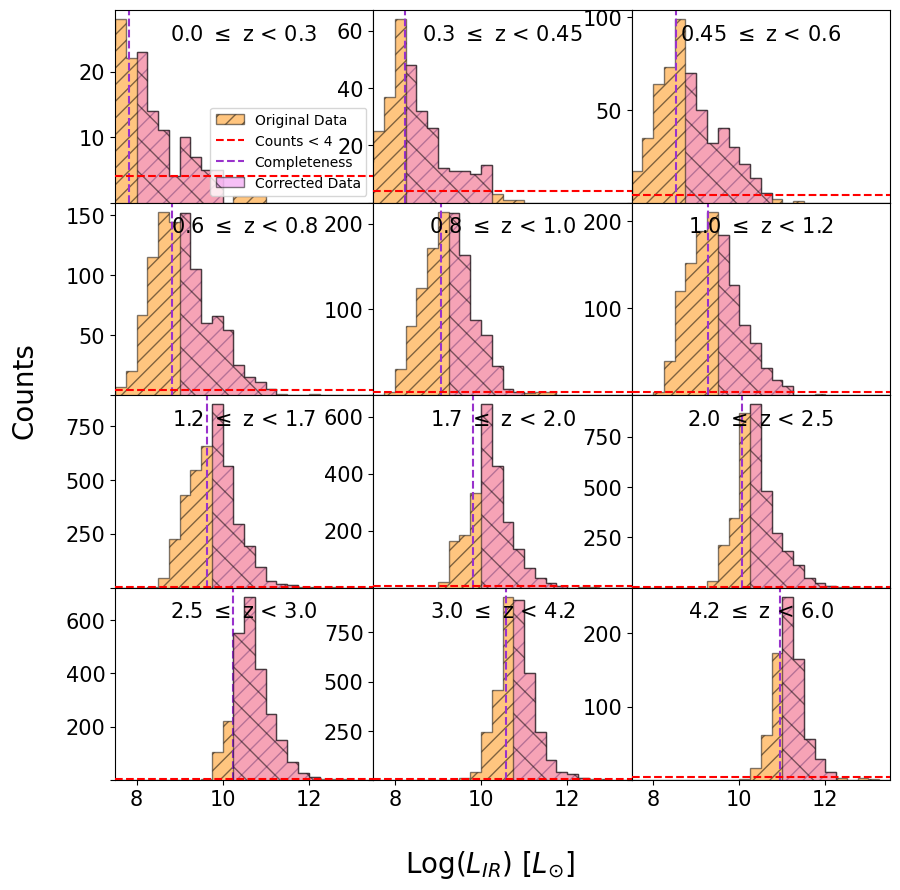

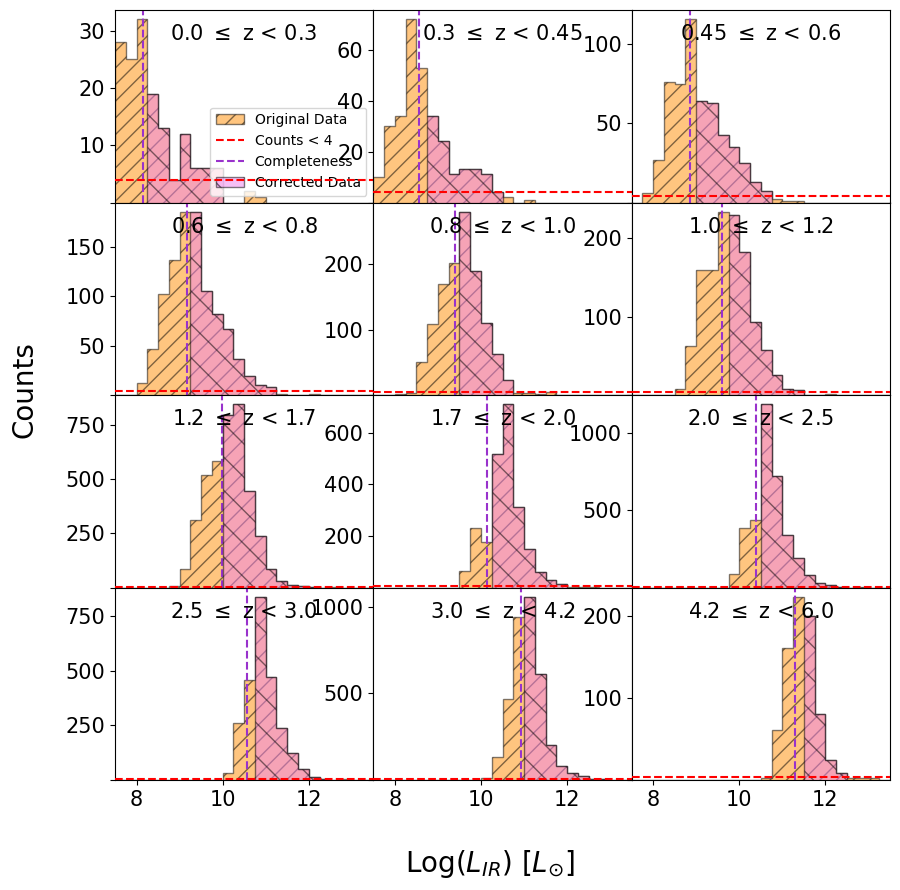

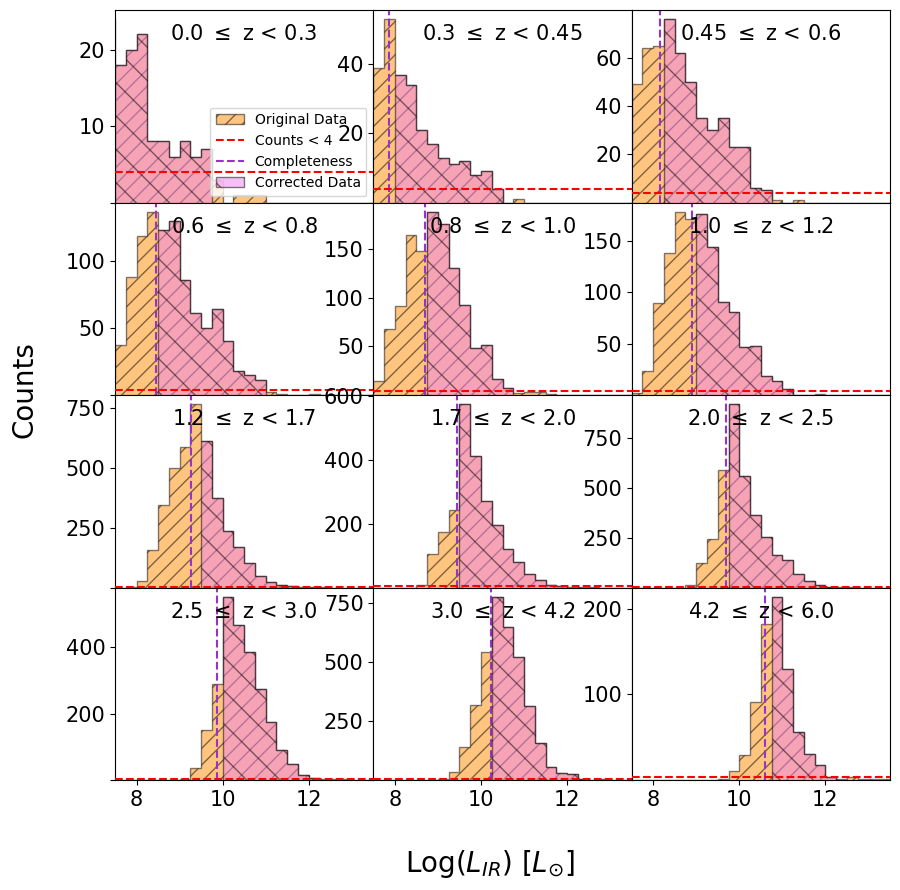

8.0 10.0
8.25 10.25
8.75 10.75
9.0 11.25
9.25 11.0
9.5 11.25
9.75 11.75
10.0 12.0
10.25 12.25
10.25 12.25
10.75 12.5
11.0 12.25


In [31]:
def get_bin_edges(redshift_bins, luminosity, all_data, L_lims):

    fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True)
    bin_edges = []
    for i, (ax, (z_start, z_end), (_, lum), min_l) in enumerate(zip(axes.flatten(), redshift_bins, all_data, L_lims)):
        
        # Bin the original data per redshift bin
        _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], 
            bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
        
        # Bin the new data with the same bins
        c, b = np.histogram(lum, bins=b)
        centers = (b[:-1] + b[1:]) / 2 # bin centers
        
        # Mask the bins with less than the minimum count
        c_mask = c >= min_count
        for _ in range(2): # should only need to run twice
            nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
            c_mask[np.where(c_mask)[0][nci + 1]] = False
        
        b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
        centers = centers[c_mask]
        c = c[c_mask]
        
        # Plot the mask cutoff
        ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}', zorder=10)
        ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label='Completeness')
        ax.set_title(f'{z_start} $\leq$ z < {z_end}', y=0.8, fontsize=15)
        
        # Skip if there are no bins
        if len(c) == 0:
            ax.legend()
            bin_edges.append([])
            continue
        
        # Plot the new, corrected data
        ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True, alpha=0.5)
        ax.tick_params(axis='both', labelsize=15)
        ax.set_xlim(7.5, 13.5)
        ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
        if i == 0:
            ax.legend(loc='lower right')
        bin_edges.append(b)
    
    fig.supylabel('Counts', fontsize=20)
    fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', fontsize=20)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
    
    return bin_edges

bin_edges = get_bin_edges(redshift_bins, luminosity, all_data, L_lims)
bin_edges_up = get_bin_edges(redshift_bins, lum_err_up, all_data_up, L_lims_up)
bin_edges_dn = get_bin_edges(redshift_bins, lum_err_dn, all_data_dn, L_lims_dn)

for i in bin_edges:
    print(min(i), max(i))

[0.00479, 0.00291, 0.00229, 0.00083, 0.00208, 0.00146, 0.00104, 0.00104]
[0.005, 0.00333, 0.00271, 0.00125, 0.00114, 0.00114, 0.00104, 0.00135]
[0.00441, 0.00315, 0.00202, 0.00252, 0.00189, 0.00132, 0.00082, 0.00031]
[0.00493, 0.00341, 0.00195, 0.00214, 0.00175, 0.00081, 0.00049, 0.00036, 0.00016]
[0.00525, 0.00401, 0.00214, 0.00172, 0.00084, 0.00017, 0.0001]
[0.00378, 0.00261, 0.00167, 0.00123, 0.00064, 0.00035, 0.00021]
[0.00587, 0.00389, 0.00204, 0.00134, 0.00067, 0.00021, 0.00012, 8e-05]
[0.00668, 0.00443, 0.00239, 0.00141, 0.00072, 0.00034, 0.00016, 7e-05]
[0.00548, 0.0029, 0.00163, 0.0011, 0.00066, 0.00028, 0.00013, 4e-05]
[0.00333, 0.00414, 0.00251, 0.00148, 0.0009, 0.00041, 0.00016, 6e-05]
[0.00244, 0.00145, 0.00065, 0.00027, 0.0001, 9e-05, 3e-05]
[0.00052, 0.00034, 0.00012, 6e-05, 2e-05]

[0.00395, 0.00271, 0.00083, 0.0025, 0.00125, 0.00125, 0.00125]
[0.00354, 0.0025, 0.00114, 0.00135, 0.00135, 0.00114, 0.00042]
[0.00403, 0.00397, 0.00271, 0.0022, 0.00157, 0.00082, 0.00044]
[0

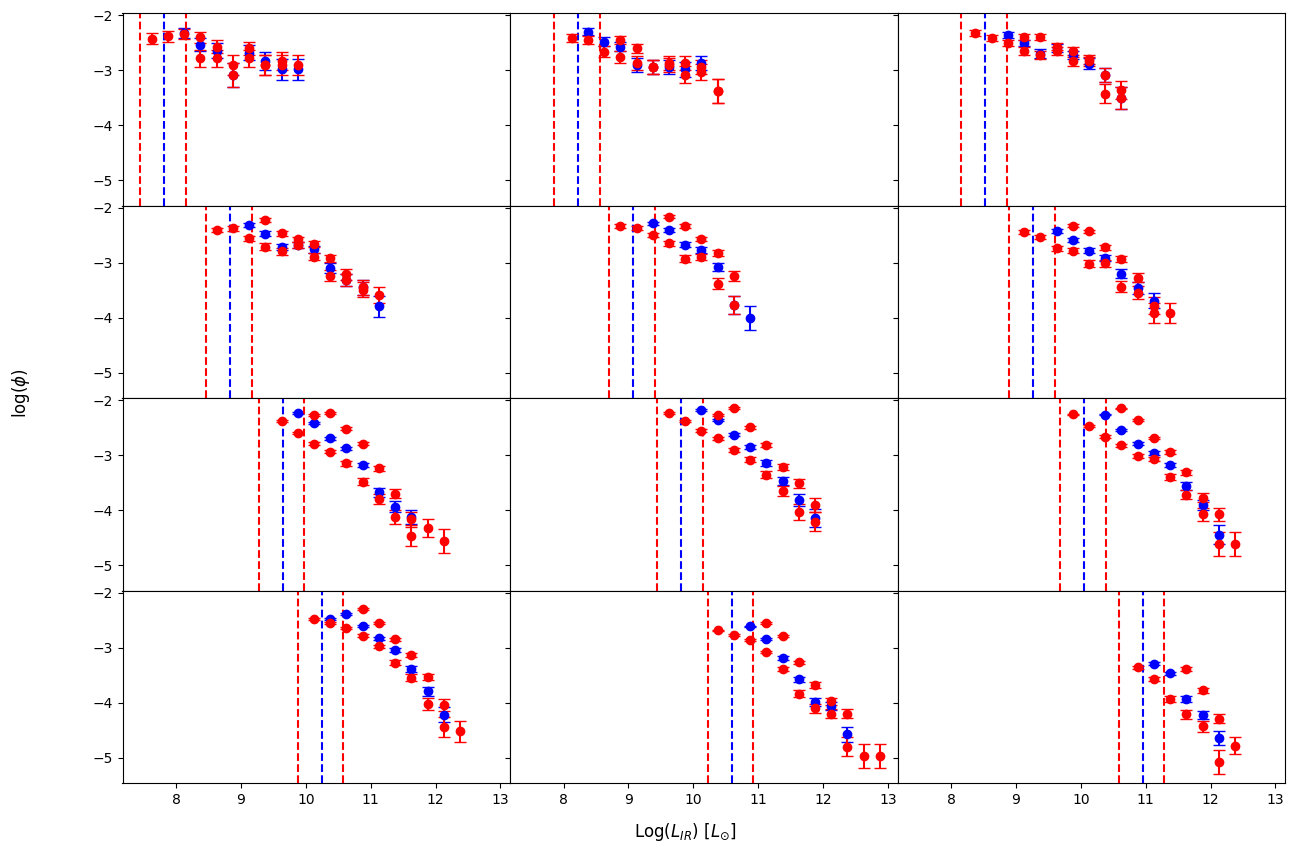

In [32]:
def number_density(all_data, bin_edges):
    lum_centers, phi, phi_e = [], [], []

    # Volume and luminosity are already binned by redshift
    for (vol, lum), bin, in zip(all_data, bin_edges):
        
        try:
            delta_log_l = np.diff(bin)[0]
        except IndexError:
            lum_centers.append([])
            phi.append([])
            phi_e.append([])
            continue
        
        lum_centers_z, phi_z, phi_e_z = [], [], []

        # Bin by luminosity
        for lum_start, lum_end in zip(bin, bin[1:]):
            mask = (lum >= lum_start) & (lum < lum_end)
            vol_lum_bin = vol[mask]
            
            # Calculate the number density
            phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
            phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
            
            # Save the luminosity bin and number density
            lum_centers_z.append((lum_start + lum_end) / 2)
            phi_z.append(phi_val)
            phi_e_z.append(phi_err)
        
        # Save the luminosity bins and number densities
        lum_centers.append(lum_centers_z)
        phi.append(np.array(phi_z))
        phi_e.append(np.array(phi_e_z))
        
    return lum_centers, phi, phi_e

lum_centers, phi, phi_e = number_density(all_data, bin_edges)
lum_centers_up, phi_up, phi_e_up = number_density(all_data_up, bin_edges_up)
lum_centers_dn, phi_dn, phi_e_dn = number_density(all_data_dn, bin_edges_dn)
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

def plot_luminosity_function(axes, lum_centers, phi, phi_e, redshift_bins, L_lims, color):
    for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), L_lims):
        try:
            yerr = np.array(e) / (np.array(p) * np.log(10))
        except TypeError:
            continue
        ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color=color)
        ax.axvline(np.log10(min_l/(3.83*10**26)), color=color, linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
        print(np.round(p,5).tolist())

plot_luminosity_function(axes, lum_centers, phi, phi_e, redshift_bins, L_lims, 'blue')
print()
plot_luminosity_function(axes, lum_centers_up, phi_up, phi_e_up, redshift_bins, L_lims_up, 'red')
print()
plot_luminosity_function(axes, lum_centers_dn, phi_dn, phi_e_dn, redshift_bins, L_lims_dn, 'red')

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('LF No Error Prop.png', bbox_inches='tight')
plt.show()   

In [33]:
# Luminosity Centers
centers = [(b[:-1] + b[1:]) / 2 for b in bin_edges]
centers_up = [(b[:-1] + b[1:]) / 2 for b in bin_edges_up]
centers_dn = [(b[:-1] + b[1:]) / 2 for b in bin_edges_dn]

# for i, (c, c_up, c_dn, p, p_up, p_dn) in enumerate(zip(centers, centers_up, centers_dn, phi, phi_up, phi_dn)):
#     # Find the indices in the original sublist (list1) and use them to extract from the array_set
#     indices_up = np.isin(c_up, c)  # Boolean mask for matching values
#     indices_dn = np.isin(c_dn, c)  # Boolean mask for matching values
    
#     # Insert 0 at the beginning if the length of c_up is less than c     
#     if len(c_up[indices_up]) < len(c):
#         c_up = np.insert(c_up[indices_up], 0, False)
#         p_up = np.insert(p_up[indices_up], 0, np.sqrt(2)*max(p_up[indices_up]))
#     else:
#         c_up = c_up[indices_up]
#         p_up = p_up[indices_up]
    
#     # Insert 0 at the end if the length of c_dn is less than c
#     if len(c_dn[indices_dn]) < len(c):
#         c_dn = np.insert(c_dn[indices_dn], len(c_dn[indices_dn]), False)
#         p_dn = np.insert(p_dn[indices_dn], len(p_dn[indices_dn]), 0)
#     else:
#         c_dn = c_dn[indices_dn]
#         p_dn = p_dn[indices_dn]
    
#     # Update the centers and phi values with the corrected values
#     centers_up[i] = c_up
#     centers_dn[i] = c_dn
#     phi_up[i] = p_up
#     phi_dn[i] = p_dn
    
# for pu, pd, pp in zip(phi_up, phi_dn, phi):
#     print(f'up: {np.round(pu,4).tolist()}')
#     print(f'p : {np.round(pp,4).tolist()}')
#     print(f'dn: {np.round(pd,4).tolist()}')
#     print()

for j, (c, c_up, c_dn, p, p_up, p_dn) in enumerate(zip(centers, centers_up, centers_dn, phi, phi_up, phi_dn)):
    # print(np.round(p_up,5).tolist())
    # print(np.round(p,5).tolist())
    # print(np.round(p_dn,5).tolist())
    # print()
    
    indices_up = np.isin(c_up, c)  # Boolean mask for matching values
    indices_dn = np.isin(c_dn, c)  # Boolean mask for matching values
    
    
    c_up = c_up[indices_up]
    c_dn = c_dn[indices_dn]
    
    p_up = p_up[indices_up]
    p_dn = p_dn[indices_dn]
    
    print('Original:')
    print(c_up)
    print(c)
    print(c_dn)
    print(np.round(p_up,5))
    print(np.round(p,5))
    print(np.round(p_dn,5))
    
    
    # Check if each value in c_up is equal to the corresponding value in c
    # If not, insert 0 at the index of the first non-matching value
    for i in range(5):
        for i, (cc, cu) in enumerate(zip(c, c_up)):
            if cu != cc and cu != 0:
                c_up = np.insert(c_up, i, cc)
                p_up = np.insert(p_up, i, p[i]+(p[i]-p_dn[i]))
                break
    
    # Insert 0 at the end if the length of c_up is less than c
    if len(c_up) < len(c):
        c_up = np.insert(c_up, len(c_up), c[-1])
        p_up = np.insert(p_up, len(p_up), p[-1]+(p[-1]-p_dn[-1]))
        
    
    # Insert 0 at the beginning if the length of c_dn is less than c
    if len(c_dn) < len(c):
        c_dn = np.insert(c_dn, len(c_dn), c[-1])
        p_dn = np.insert(p_dn, len(p_dn), p[-1]-(p_up[-1]-p[-1]))
    
    # Update the centers and phi values with the corrected values
    centers_up[j] = c_up
    centers_dn[j] = c_dn
    phi_up[j] = p_up
    phi_dn[j] = p_dn
    
    print('Fixed:')
    print(c_up)
    print(c)
    print(c_dn)
    print(np.round(p_up,5))
    print(np.round(p,5))
    print(np.round(p_dn,5))
    print()
    

    
    


Original:
[8.375 8.625 8.875 9.125 9.375 9.625 9.875]
[8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875]
[8.125 8.375 8.625 8.875 9.125 9.375 9.625]
[0.00395 0.00271 0.00083 0.0025  0.00125 0.00125 0.00125]
[0.00479 0.00291 0.00229 0.00083 0.00208 0.00146 0.00104 0.00104]
[0.00458 0.00166 0.00166 0.00125 0.00166 0.00125 0.00146]
Fixed:
[8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875]
[8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875]
[8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875]
[0.00499 0.00395 0.00271 0.00083 0.0025  0.00125 0.00125 0.00125]
[0.00479 0.00291 0.00229 0.00083 0.00208 0.00146 0.00104 0.00104]
[0.00458 0.00166 0.00166 0.00125 0.00166 0.00125 0.00146 0.00083]

Original:
[ 8.875  9.125  9.375  9.625  9.875 10.125]
[ 8.375  8.625  8.875  9.125  9.375  9.625  9.875 10.125]
[ 8.375  8.625  8.875  9.125  9.375  9.625  9.875 10.125]
[0.00354 0.0025  0.00114 0.00135 0.00135 0.00114]
[0.005   0.00333 0.00271 0.00125 0.00114 0.00114 0.00104 0.00135]
[0.00354 0.00219 0.00177 0.0

[0.00479, 0.00291, 0.00229, 0.00083, 0.00208, 0.00146, 0.00104, 0.00104]
[0.005, 0.00333, 0.00271, 0.00125, 0.00114, 0.00114, 0.00104, 0.00135]
[0.00441, 0.00315, 0.00202, 0.00252, 0.00189, 0.00132, 0.00082, 0.00031]
[0.00493, 0.00341, 0.00195, 0.00214, 0.00175, 0.00081, 0.00049, 0.00036, 0.00016]
[0.00525, 0.00401, 0.00214, 0.00172, 0.00084, 0.00017, 0.0001]
[0.00378, 0.00261, 0.00167, 0.00123, 0.00064, 0.00035, 0.00021]
[0.00587, 0.00389, 0.00204, 0.00134, 0.00067, 0.00021, 0.00012, 8e-05]
[0.00668, 0.00443, 0.00239, 0.00141, 0.00072, 0.00034, 0.00016, 7e-05]
[0.00548, 0.0029, 0.00163, 0.0011, 0.00066, 0.00028, 0.00013, 4e-05]
[0.00333, 0.00414, 0.00251, 0.00148, 0.0009, 0.00041, 0.00016, 6e-05]
[0.00244, 0.00145, 0.00065, 0.00027, 0.0001, 9e-05, 3e-05]
[0.00052, 0.00034, 0.00012, 6e-05, 2e-05]

[0.00479, 0.00291, 0.00229, 0.00083, 0.00208, 0.00146, 0.00104, 0.00104, 0.00041, 0.00013, 7e-05, 5e-05]
[0.005, 0.00333, 0.00271, 0.00125, 0.00114, 0.00114, 0.00104, 0.00135, 0.001, 0.00026,

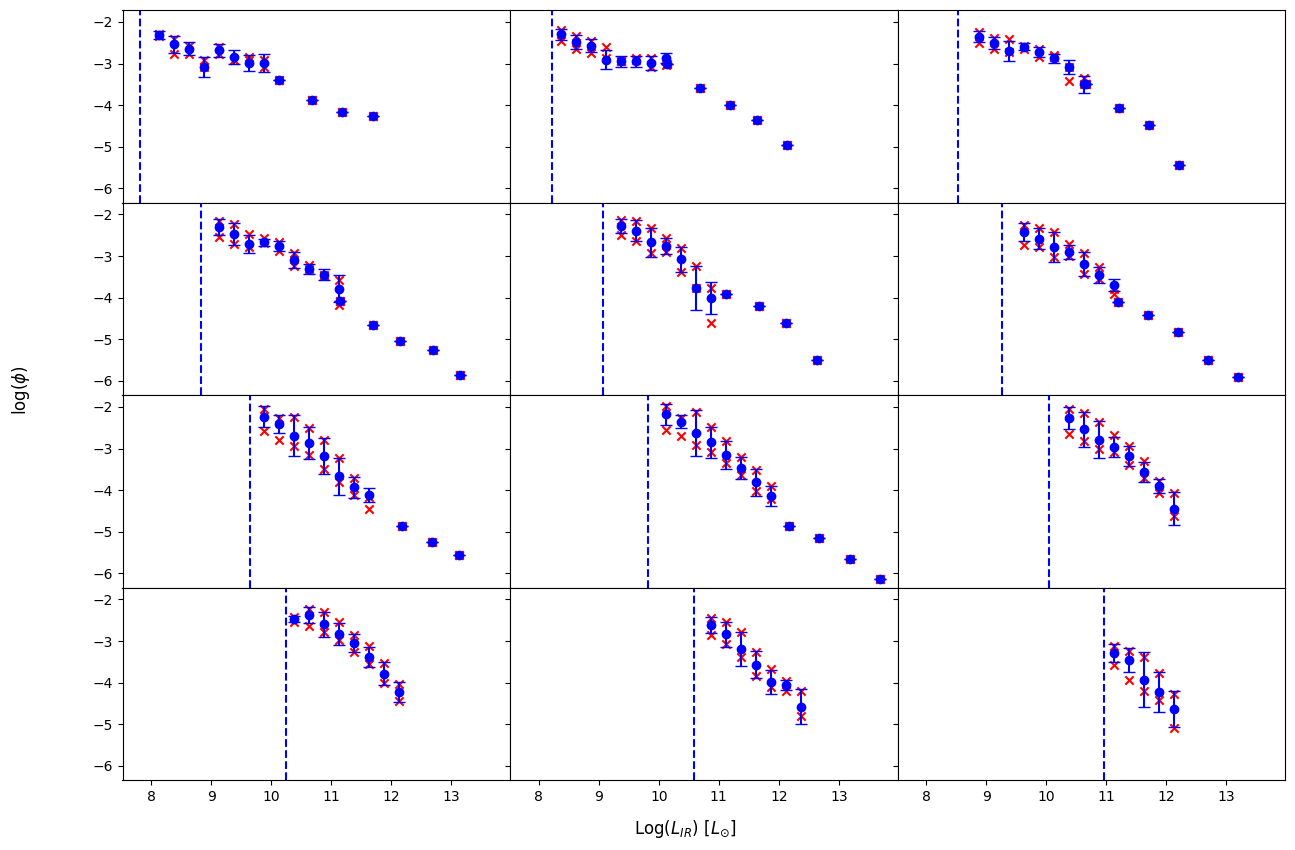

In [34]:
phi_err_total = []

for p_e, p_up, p_dn in zip(phi_e, phi_up, phi_dn):
    
    # Compute luminosity error contribution
    phi_err_lum = np.abs(p_up - p_dn) / 2

    # Total error
    phi_err_bin = np.sqrt(p_e**2 + phi_err_lum**2)
    phi_err_total.append(phi_err_bin)
    
for i in phi:
    print(np.round(i,5).tolist())
print()

""" THORNE AGN ADDITIONAL FITTING"""
T_L_028 = [5.10e+43, 1.82e+44, 5.87e+44, 1.89e+45]
T_L_045 = [5.33e+43, 1.873e+44, 5.92e+44, 1.68e+45, 5.33e+45]
T_L_056 = [1.75e+44, 6.22e+44, 1.98e+45, 6.33e+45]
T_L_082 = [5.33e+44, 1.87e+45, 5.33e+45, 1.87e+46, 5.33e+46]
T_L_10 = [5.03e+44, 1.78e+45, 5.12e+45, 1.63e+46]
T_L_12 = [5.92e+44, 1.87e+45, 5.92e+45, 1.87e+46, 5.92e+46]
T_L_175 = [5.69e+45, 1.81e+46, 5.21e+46]
T_L_220 = [5.69e+45, 1.81e+46, 5.79e+46, 1.85e+47]
T_L = [T_L_028, T_L_045, T_L_056, T_L_082, T_L_10, T_L_12, T_L_175, T_L_220]
    
T_P_028 = [0.00041, 0.00013, 0.000068, 0.000054]
T_P_045 = [0.0010, 0.00026, 0.00010, 0.000043, 0.000011]
T_P_056 = [0.00033, 0.000085, 0.000034, 0.0000036]
T_P_082 = [0.000085, 0.000022, 0.0000089, 0.0000056, 0.0000014]
T_P_10 = [0.00012, 0.000063, 0.000025, 0.0000031]
T_P_12 = [0.000079, 0.000039, 0.000015, 0.0000031, 0.0000012]
T_P_175 = [0.000014, 0.0000056, 0.0000028]
T_P_220 = [0.000014, 0.0000071, 0.0000022, 7.39e-7]
T_P = [T_P_028, T_P_045, T_P_056, T_P_082, T_P_10, T_P_12, T_P_175, T_P_220]

for i in range(len(T_P)):
    phi[i] = np.append(phi[i], np.array(T_P[i]))
    phi_err_total[i] = np.append(phi_err_total[i], np.zeros(len(T_P[i])))
    phi_up[i] = np.append(phi_up[i], np.array(T_P[i]))
    phi_dn[i] = np.append(phi_dn[i], np.array(T_P[i]))
    
    lum_centers[i] = np.append(lum_centers[i], np.log10(np.array(T_L[i])*(2.612*10**-34)))
    centers_up[i] = np.append(centers_up[i], np.log10(np.array(T_L[i])*(2.612*10**-34)))
    centers_dn[i] = np.append(centers_dn[i], np.log10(np.array(T_L[i])*(2.612*10**-34)))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
plot_luminosity_function(axes, lum_centers, phi, phi_err_total, redshift_bins, L_lims, 'blue')
for ax, cen_up, cen_down, pu, pd in zip(axes.flatten(), centers_up, centers_dn, phi_up, phi_dn):
    ax.scatter(cen_up, np.log10(pu), color='red', label='Up Error', marker='x')
    ax.scatter(cen_down, np.log10(pd), color='red', label='Down Error', marker='x')
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()   

C:\Users\danie\AppData\Local\Temp\ipykernel_14104\1354688844.py:36: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\danie\AppData\Local\Temp\ipykernel_14104\1354688844.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *(params+perr))),
C:\Users\danie\AppData\Local\Temp\ipykernel_14104\1354688844.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))), color='red', alpha=0.2)


0.0 <= z < 0.3 Function fit:
Lstar:    10.262 +- 0.467
phi_star: -3.061 +- 0.271

0.3 <= z < 0.45 Function fit:
Lstar:    10.542 +- 0.559
phi_star: -3.047 +- 0.392

0.45 <= z < 0.6 Function fit:
Lstar:    10.6 +- 0.182
phi_star: -2.904 +- 0.211

0.6 <= z < 0.8 Function fit:
Lstar:    10.484 +- 0.362
phi_star: -2.749 +- 0.338

0.8 <= z < 1.0 Function fit:
Lstar:    10.196 +- 0.208
phi_star: -2.467 +- 0.195

1.0 <= z < 1.2 Function fit:
Lstar:    10.516 +- 0.059
phi_star: -2.656 +- 0.259

1.2 <= z < 1.7 Function fit:
Lstar:    10.497 +- 0.339
phi_star: -2.326 +- 0.184

1.7 <= z < 2.0 Function fit:
Lstar:    10.735 +- 0.345
phi_star: -2.262 +- 0.2

2.0 <= z < 2.5 Function fit:
Lstar:    10.866 +- 0.211
phi_star: -2.294 +- 0.253

2.5 <= z < 3.0 Function fit:
Lstar:    11.492 +- 0.191
phi_star: -2.697 +- 0.125

3.0 <= z < 4.2 Function fit:
Lstar:    11.251 +- 0.246
phi_star: -2.545 +- 0.145

4.2 <= z < 6.0 Function fit:
Lstar:    11.494 +- 0.448
phi_star: -3.204 +- 0.122



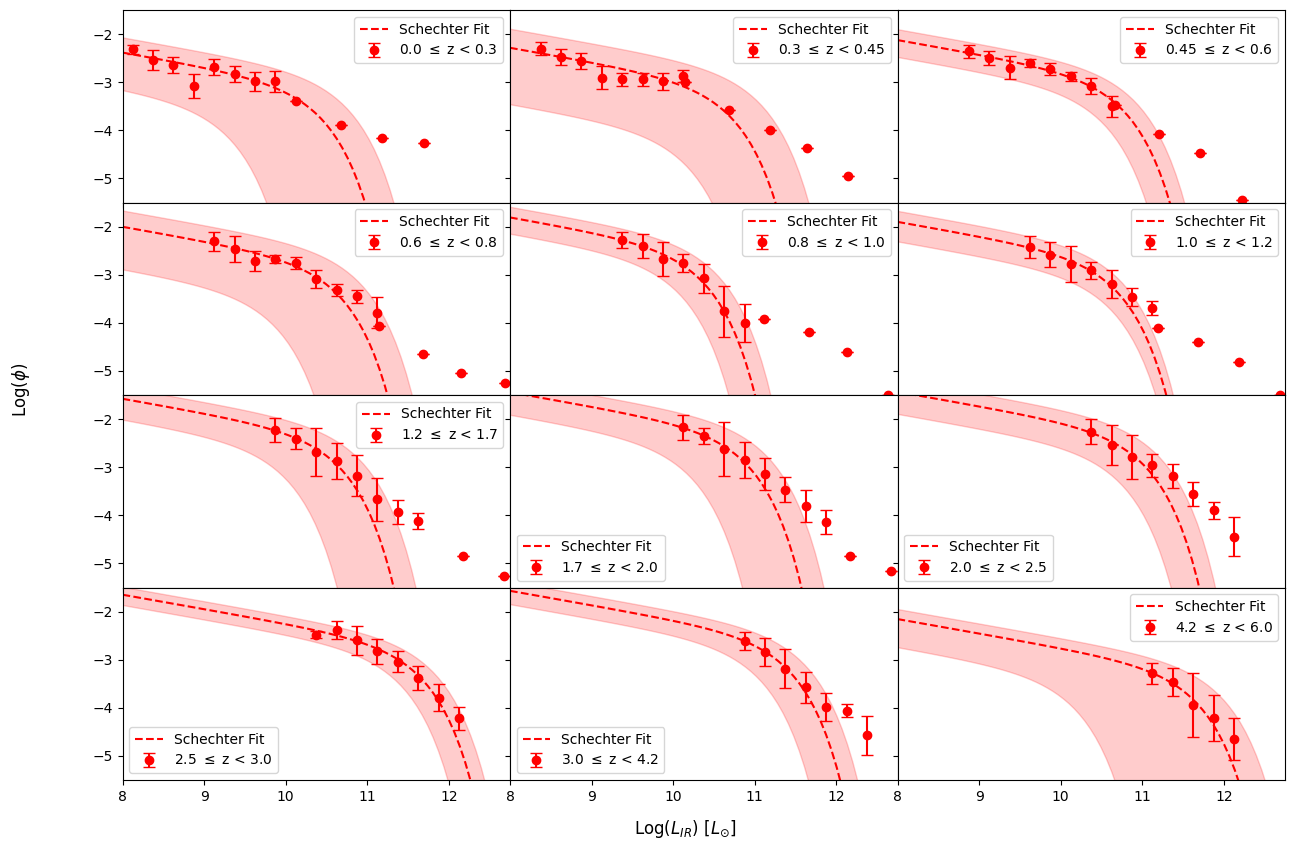

In [35]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, p_up, p_dn, e, ax in zip(redshift_bins, lum_centers, phi, phi_up, phi_dn, phi_err_total, axes.flatten()):
    
    # Attempt to fit the data
    lum = np.power(10, lum)
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit the data
    up_params, up_covars = curve_fit(schechter_luminosity, lum, p_up, p0=p0, bounds=bounds, maxfev=1000)
    params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
    dn_params, dn_covars = curve_fit(schechter_luminosity, lum, p_dn, p0=p0, bounds=bounds, maxfev=1000)
    
    # # Error on the parameters
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    sig = (up_e + dn_e) / 2
    perr = np.sqrt(perr**2 + sig**2)
    
    # Plot the data
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, fmt='o', capsize=4, color='red', label=f'{z_start} $\leq$ z < {z_end}')
    
    # Plot the Schechter function
    long_lum = np.logspace(8, 14.5, 100)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    
    ax.fill_between(np.log10(long_lum), 
        np.log10(schechter_luminosity(long_lum, *(params+perr))), 
        np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))), color='red', alpha=0.2)
    ax.set_ylim(-5.5, -1.5)
    ax.set_xlim(8, 12.75)
    ax.legend()
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Lstar:    {np.round(np.log10(params[0]),3)} +- {np.round(perr[0] / (params[0]*np.log(10)),3)}')
    print(f'phi_star: {np.round(np.log10(params[1]),3)} +- {np.round(perr[1] / (params[1]*np.log(10)),3)}')
    print()
    
    schecter_params.append(params)
    schecter_errors.append(perr)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

0.0 <= z < 0.3 Function fit:
Lstar:    7.853 +- 0.627
phi_star: -2.34 +- 0.283

0.3 <= z < 0.45 Function fit:
Lstar:    8.097 +- 0.357
phi_star: -2.297 +- 0.278

0.45 <= z < 0.6 Function fit:
Lstar:    8.664 +- 0.193
phi_star: -2.325 +- 0.242

0.6 <= z < 0.8 Function fit:
Lstar:    8.844 +- 0.172
phi_star: -2.269 +- 0.294

0.8 <= z < 1.0 Function fit:
Lstar:    9.074 +- 0.308
phi_star: -2.227 +- 0.323

1.0 <= z < 1.2 Function fit:
Lstar:    9.344 +- 0.146
phi_star: -2.355 +- 0.306

1.2 <= z < 1.7 Function fit:
Lstar:    9.574 +- 0.181
phi_star: -2.146 +- 0.34

1.7 <= z < 2.0 Function fit:
Lstar:    9.844 +- 0.255
phi_star: -2.055 +- 0.258

2.0 <= z < 2.5 Function fit:
Lstar:    10.093 +- 0.171
phi_star: -2.173 +- 0.397

2.5 <= z < 3.0 Function fit:
Lstar:    10.455 +- 0.507
phi_star: -2.388 +- 0.185

3.0 <= z < 4.2 Function fit:
Lstar:    10.574 +- 0.283
phi_star: -2.512 +- 0.362

4.2 <= z < 6.0 Function fit:
Lstar:    10.824 +- 0.316
phi_star: -3.178 +- 0.405



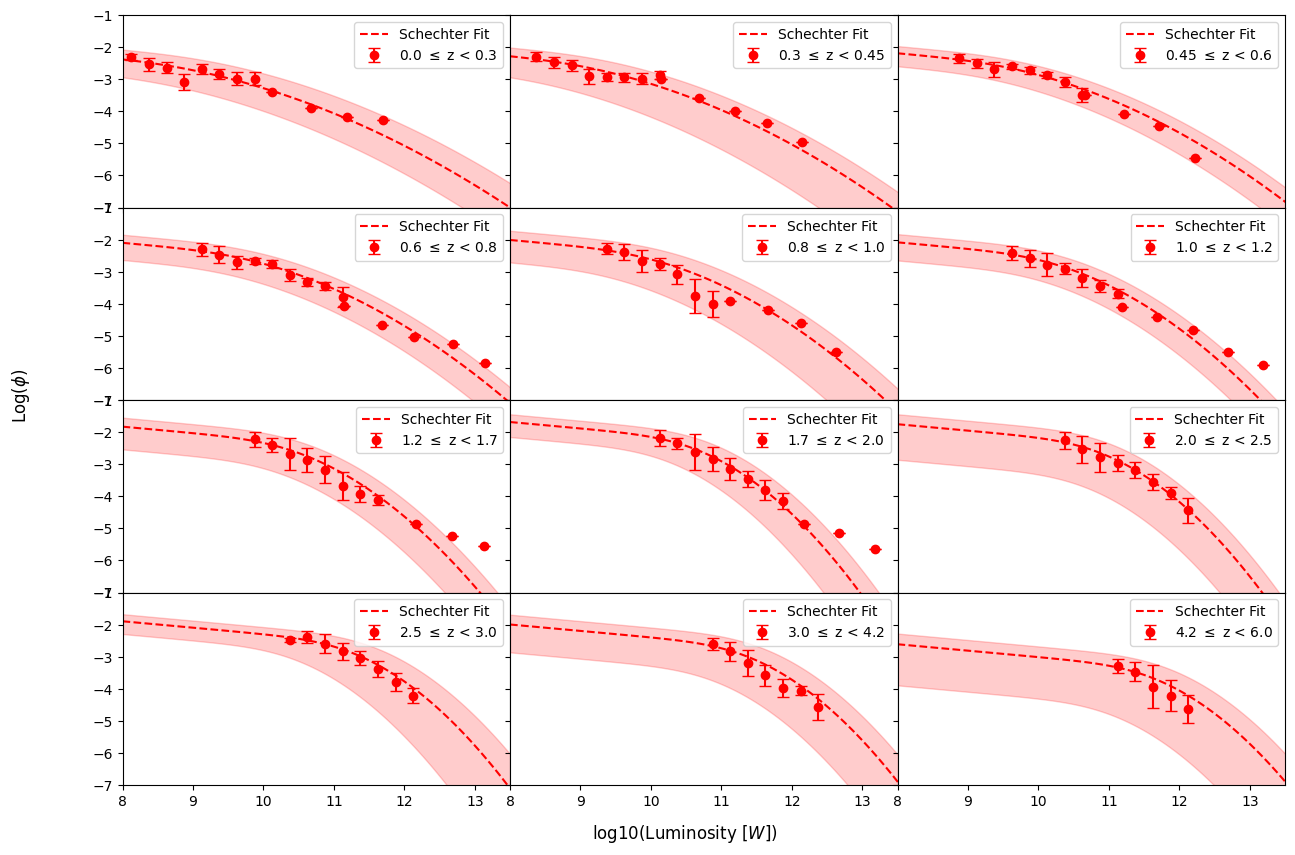

In [42]:
def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
# sigmas = [1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
sigmas = [1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7]
# sigmas = [1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
# sigmas = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
# sigmas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# sigmas = [1.4, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, p_up, p_dn, e, ax, sigma in zip(redshift_bins, lum_centers, phi, phi_up, phi_dn, phi_err_total, axes.flatten(), sigmas):
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit the data
    up_params, up_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_up, p0=p0, bounds=bounds, maxfev=10000)
    params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000)
    dn_params, dn_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_dn, p0=p0, bounds=bounds, maxfev=10000)
    
    # Error on the parameters
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    sig = (up_e + dn_e) / 2
    perr = np.sqrt(perr**2 + sig**2)
    
    # Plot the data
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, fmt='o', capsize=4, color='red', label=f'{z_start} $\leq$ z < {z_end}')
    
    # Plot the Saunders function
    long_lum = np.logspace(8, 14.5, 100)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='red', label='Schechter Fit', linestyle='--')
    
    # Fill between
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *(params+perr), sigma)), 
        np.log10(saunders_luminosity(long_lum, *np.abs(params-perr), sigma)), color='red', alpha=0.2)
    # ax.set_xlim(8, 12.75)
    # ax.set_ylim(-5.5, -1.5)
    ax.set_xlim(8, 13.5)
    ax.set_ylim(-7, -1)
    ax.legend()
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Lstar:    {np.round(np.log10(params[0]),3)} +- {np.round(perr[0] / (params[0]*np.log(10)),3)}')
    print(f'phi_star: {np.round(np.log10(params[1]),3)} +- {np.round(perr[1] / (params[1]*np.log(10)),3)}')
    print()
    
    saunder_params.append(params)
    saunder_error.append(perr)
    
fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Remove Thorne AGN  
# for i in range(len(T_L)):
#     phi[i] = phi[i][:-len(T_L[i])]
#     phi_up[i] = phi_up[i][:-len(T_L[i])]
#     phi_dn[i] = phi_dn[i][:-len(T_L[i])]
#     lum_centers[i] = lum_centers[i][:-len(T_L[i])]
#     phi_err_total[i] = phi_err_total[i][:-len(T_L[i])]

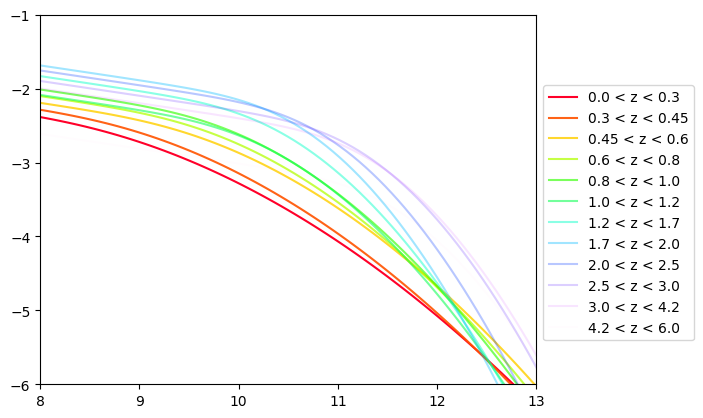

In [43]:
long_lum = np.logspace(8, 14.5, 100)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))
alphas = np.linspace(1, 0.01, len(redshift_bins))
for p, sp, e, s, c, (zs, ze), a in zip(phi, saunder_params, phi_err_total, sigmas, colors, redshift_bins, alphas):  
    yerr = e / (p * np.log(10))
    plt.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *sp, s)), color=c, label=f'{zs} < z < {ze}', alpha=a)

plt.xlim(8, 13)
plt.ylim(-6, -1)
plt.legend(bbox_to_anchor=(1.0, 0.10))
plt.show()

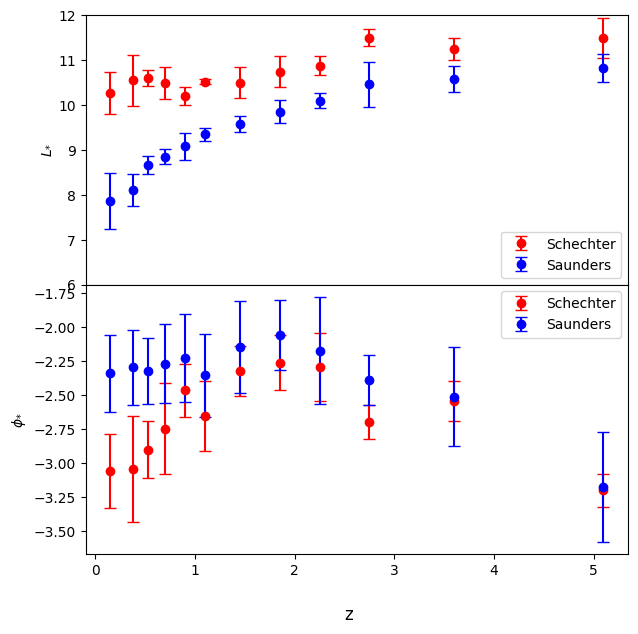

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
mean_z = np.mean(redshift_bins, axis=1)

ax[0].errorbar(mean_z, np.log10(np.array(schecter_params).T[0]), yerr=(np.array(schecter_errors).T[0] / (np.array(schecter_params).T[0] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[0].errorbar(mean_z, np.log10(np.array(saunder_params).T[0]), yerr=(np.array(saunder_error).T[0] / (np.array(saunder_params).T[0] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[0].set_ylabel('$L_{*}$')
ax[0].legend(loc='lower right')
ax[0].set_ylim(6, 12)

ax[1].errorbar(mean_z, np.log10(np.array(schecter_params).T[1]), yerr=(np.array(schecter_errors).T[1] / (np.array(schecter_params).T[1] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[1].errorbar(mean_z, np.log10(np.array(saunder_params).T[1]), yerr=(np.array(saunder_error).T[1] / (np.array(saunder_params).T[1] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[1].set_ylabel('$\phi_{*}$')
ax[1].legend(loc='upper right')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

[array([ 8.125     ,  8.375     ,  8.625     ,  8.875     ,  9.125     ,
        9.375     ,  9.625     ,  9.875     , 10.12454335, 10.67704456,
       11.18561127, 11.69343498]), array([ 8.375     ,  8.625     ,  8.875     ,  9.125     ,  9.375     ,
        9.625     ,  9.875     , 10.125     , 10.14370038, 10.68951095,
       11.18929488, 11.64228245, 12.14370038]), array([ 8.875     ,  9.125     ,  9.375     ,  9.625     ,  9.875     ,
       10.125     , 10.375     , 10.625     , 10.66001122, 11.21076356,
       11.71363836, 12.21837688]), array([ 9.125     ,  9.375     ,  9.625     ,  9.875     , 10.125     ,
       10.375     , 10.625     , 10.875     , 11.125     , 11.14370038,
       11.68881478, 12.14370038, 12.68881478, 13.14370038]), array([ 9.375     ,  9.625     ,  9.875     , 10.125     , 10.375     ,
       10.625     , 10.875     , 11.11854116, 11.66739317, 12.12624313,
       12.62916078]), array([ 9.625     ,  9.875     , 10.125     , 10.375     , 10.625     ,
      

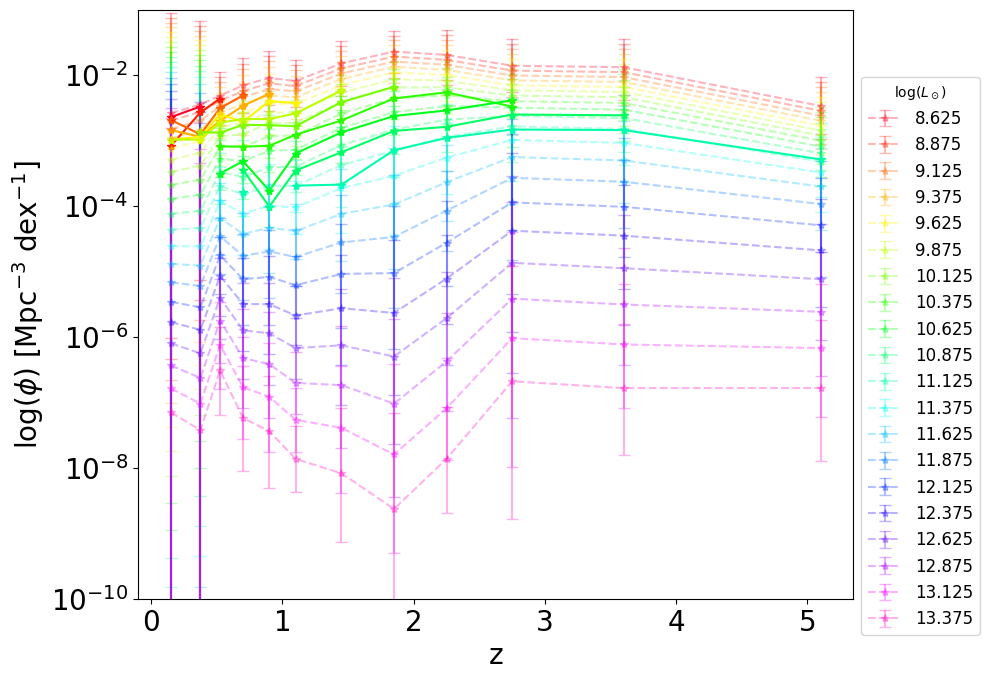

In [40]:
redshift_centers = np.mean(redshift_bins, axis=1)
# luminosity_classes = np.arange(8, 13.5, 0.5)
luminosity_classes = np.arange(8.625, 13.625, 0.25)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
plt.figure(figsize=(10, 7))
print(lum_centers)

class_phi = []
for lum in luminosity_classes:
    lum_phi = []
    for para, per, sig in zip(saunder_params, saunder_error, sigmas):
        err = per / (para*np.log(10))
        
        phis = saunders_luminosity(10**lum, *para, sig)
        pup = saunders_luminosity(10**lum, *(10**(np.log10(para) + err)), sig)
        pdn = saunders_luminosity(10**lum, *(10**(np.log10(para) - err)), sig)
        lum_phi.append([phis, pup-phis, phis-pdn])
    class_phi.append(lum_phi)

for lum, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    plt.errorbar(redshift_centers, class_lum[:,0], yerr=[class_lum[:,2], class_lum[:,1]], ls='--', capsize=4, marker='*', label=f'{lum}', color=c, alpha=0.3)

plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.yscale('log')
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.xticks([0,1,2,3,4,5])
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.ylim(10**-10, 10**-1)
# plt.show()
    
# Step 1: Create a dict of dicts
from collections import defaultdict
combined = defaultdict(lambda: [None] * len(phi))

# Step 2: Populate the combined dict
for i, (x_vals, densities) in enumerate(zip(lum_centers, phi)):
    for x, d in zip(x_vals, densities):
        combined[x][i] = d

# Step 3: Sort and print the result
merged = sorted(combined.items())  # List of (x, [density1, density2, density3])

# print(redshift_centers)

skip_count = 0
for i, ((x, densities), c) in enumerate(zip(merged[2:], colors)):
    if x not in luminosity_classes:
        # print(f'skiped {x}')
        skip_count -= 1
        continue
    print(f"{x}: {densities}, {c}")
    plt.plot(redshift_centers, densities, color=colors[i+skip_count], marker='*')
    
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.show()

up_e = [4.57383e+03 7.51010e+02 1.05000e+00 1.21000e+00 1.21000e+00 6.10000e-01
 1.02000e+00 1.25000e+00 9.00000e-01 2.56000e+00 1.26000e+00 1.44000e+00]
area = [7.31 7.32 7.93 7.76 7.88 7.85 8.15 8.34 8.48 8.67 8.62 8.21]
dn_e = [0.43 0.43 0.31 0.32 0.32 0.25 0.3  0.32 0.29 0.37 0.32 0.33] 

0.0 <= z < 0.3 - LD Cont - FIRGs: 45.48% - LIRGs: 27.14% - ULIRGs: 27.38% - Dominant: FIRG
0.3 <= z < 0.45 - LD Cont - FIRGs: 56.07% - LIRGs: 26.13% - ULIRGs: 17.8% - Dominant: FIRG
0.45 <= z < 0.6 - LD Cont - FIRGs: 36.68% - LIRGs: 32.24% - ULIRGs: 31.09% - Dominant: FIRG
0.6 <= z < 0.8 - LD Cont - FIRGs: 56.82% - LIRGs: 29.21% - ULIRGs: 13.97% - Dominant: FIRG
0.8 <= z < 1.0 - LD Cont - FIRGs: 61.35% - LIRGs: 28.77% - ULIRGs: 9.88% - Dominant: FIRG
1.0 <= z < 1.2 - LD Cont - FIRGs: 64.97% - LIRGs: 28.26% - ULIRGs: 6.76% - Dominant: FIRG
1.2 <= z < 1.7 - LD Cont - FIRGs: 67.92% - LIRGs: 27.69% - ULIRGs: 4.39% - Dominant: FIRG
1.7 <= z < 2.0 - LD Cont - FIRGs: 71.1% - LIRGs: 26.43% - ULIRGs: 2.48%

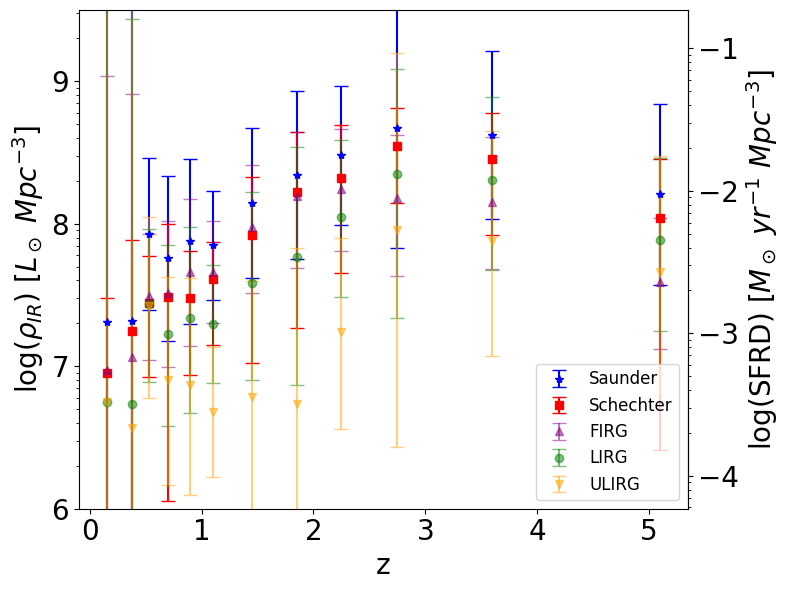

In [41]:
# lower_bound = 10**8
# upper_bound = 10**14

full_lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
full_lower_bounds[0] = 0
full_upper_bounds = full_lower_bounds[1:] + [np.inf]

fig, ax = plt.subplots(figsize=(8, 6))
from scipy import integrate
from matplotlib.ticker import LogFormatterExponent

def kennicutt_sfr(rho_ir):
    return rho_ir / (1.7*10**10)

def inverse_kennicutt_sfr(sfr):
    return sfr * 1.7*10**10

def saunder_area(params, perrors, sigmas, lb, ub):
    results_area = []
    for param, perr, sigma in zip(params, perrors, sigmas):
        pars_up = 10**(np.log10(param) + (perr / (param*np.log(10))))
        pars_down = 10**(np.log10(param) - (perr / (param*np.log(10))))
        
        param = np.append(param, sigma)
        perr = np.append(perr, 0)
        pars_up = np.append(pars_up, sigma)
        pars_down = np.append(pars_down, sigma)
        
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(pars_up)) / np.log(10)
            area_down, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(pars_down)) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

def schechter_area(params, perrors, lb, ub):
    results_area = []
    for param, perr in zip(params, perrors):
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

""" Saunder """
total_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, total_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='*', label='Saunder', color='Blue')
print(f'up_e = {np.round(area_up / (total_area* np.log(10)),2)}')
print(f'area = {np.round(np.log10(total_area),2)}')
print(f'dn_e = {np.round(area_down / (total_area* np.log(10)),2)}', '\n')
    
""" Schechter """
area, area_up, area_down = schechter_area(schecter_params, schecter_errors, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, area, yerr=[area_down, area_up], ls='none', capsize=5, marker='s', label='Schechter', color='red')

""" Saunder FIRG Contribution """
FIRG_LB = [0,      10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
FIRG_UB = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10, 10**11]
FIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, FIRG_LB, FIRG_UB)
ax.errorbar(redshift_centers, FIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='^', label='FIRG', color='purple', alpha=0.5)

""" Saunder LIRG Contribution """
LIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, [10**11], [10**12])
ax.errorbar(redshift_centers, LIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='o', label='LIRG', color='green', alpha=0.5)

""" Saunder ULIRG Contribution """
ULIRG_LB = [10**12, 10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28]
ULIRG_UB = [10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28, np.inf]
ULIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, ULIRG_LB, ULIRG_UB)
ax.errorbar(redshift_centers, ULIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='v', label='ULIRG', color='orange', alpha=0.5)

# Relative Contributions
total_area = np.array(total_area)
FIRG_area = np.round((np.array(FIRG_area) / total_area)*100, 2)
LIRG_area = np.round((np.array(LIRG_area) / total_area)*100, 2)
ULIRG_area = np.round((np.array(ULIRG_area) / total_area)*100, 2)
for FD, LD, UD, (z_start, z_end) in zip(FIRG_area, LIRG_area, ULIRG_area, redshift_bins):
    if FD > LD and FD > UD:
        field = 'FIRG'
    elif LD > FD and LD > UD:
        field = 'LIRG'
    else:
        field = 'ULIRG'
    print(f'{z_start} <= z < {z_end} - LD Cont - FIRGs: {FD}% - LIRGs: {LD}% - ULIRGs: {UD}% - Dominant: {field}')

# Luminosity Density
ax.set_ylabel(r'log($\rho_{IR}$) [$L_\odot$ $Mpc^{-3}$]', fontsize=20)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel('z', fontsize=20)
ax.set_xticks([0,1,2,3,4,5])
# ax.set_ylim(10**7, 10**10)
ax.set_ylim(10**6, 10**9.5)
ax.tick_params(axis='both', labelsize=20)
ax.yaxis.set_major_formatter(LogFormatterExponent(base=10))

# SFRD Secondary Axis
secax = ax.secondary_yaxis('right', functions=(kennicutt_sfr, inverse_kennicutt_sfr))
secax.set_ylabel('log(SFRD) [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]', fontsize=20)
secax.yaxis.set_major_formatter(LogFormatterExponent(base=10))
secax.tick_params(labelsize=20)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# # print(odf.head())
# # print(np.log10(odf['bayes.agn.luminosity']/(3.83*10**26)))

# # For every list of redshifts in the binned redshift bins
# final_index = []
# for _, lb in all_data:
    
#     # For every redshift value in the list of redshifts, find the ID of the value
#     for k, i in enumerate(lb):
#         val = odf.loc[np.log10(odf['bayes.agn.luminosity']/(3.83*10**26)) == i].index[0]
#         final_index.append(val)

# import pandas as pad

# print(len(final_index))
# print(len(set(final_index)))
# print(sorted(final_index))
# new_df = pad.DataFrame(final_index, columns=['index'])
# new_df.to_csv('final_index.csv', index=False)

In [ ]:
file_name = 'fits/CIGALE_AGN_UPDATE2'
np.savez(file_name,
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object),
    e=np.array(phi_err_total, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(L_lims, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object),
    reduced_lums=np.array(reduced_lums, dtype=object),
    bin_zs=np.array(bin_zs, dtype=object),
    old_lums=np.array(luminosity, dtype=object),
    old_zs=np.array(z, dtype=object))